TF-IDF로 데이터 스케일 변경하기 

- 중요하지 않아 보이는 특성을 제거하는 대신, 얼마나 의미 있는 특성인지를 계산해서 스케일을 조정하는 방식
- 말뭉치의 다른 문서보다 특정 문서에 자주 나타나는 단어에 높은 가중 치를 주는 방법
- 사이킷런의 TfidTransformer는 CountVectorizer가 만든 희소행렬을 입력 받아 BOW특성 추출, TF-IDF변환 수행
- L2정규화를 통해 유클리디안 노름이 1이 되도록 각 문서 벡터의 스케일을 변경한다.
  
  ( 단어의 수에 영향을 받지 않게 된다. )

In [1]:
import wget
import numpy as np
from sklearn.datasets import load_files



c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
reviews_train = load_files('aclImdb_v1.tar/aclImdb/train/')

#텍스트, 레이블 포함한 Brunch 오브젝트 반환

text_train, y_train = reviews_train.data, reviews_train.target

print('text_train 타입 : ', type(text_train))
print('text_train 길이 :', len(text_train))
print('text_train[6]:\n', text_train[6])

KeyboardInterrupt: 

In [ ]:
text_train = [doc.replace(b"<br />",b"") for doc in text_train]

reviews_test = load_files('aclImdb_v1.tar/aclImdb/test/')
text_test, y_test = reviews_test.data, reviews_test.target

print('테스트 데이터 문서 수 : ', len(reviews_test))
print('클래스별 샘플수 (테스트) :', np.bincount(y_test))
text_test = [doc.replace(b"<br />", b"")for doc in text_test]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [5]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5), LogisticRegression())
param_grid = {'logisticregression__C':[0.001,0.01,0.1,1,10]}

grid = GridSearchCV(pipe, param_grid , cv =5)
grid.fit(text_train, y_train)
print('최상 교차 검증 점수 :', grid.best_score_)

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Futur

최상 교차 검증 점수 : 0.7228533333333333


- tf-idf가 모델의 성능에 큰 영향을 주지 못했다. 
- tf-idf는 어떤 단어가 중요한지도 알려준다. 
- tf-idf 변환은 문서를 구별하는 단어를 찾는 방법이지만 완전히 비지도 학습이다. 

In [7]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

X_train = vectorizer.transform(text_train)

#특성별로 가장 큰값 탐색
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf=max_value.argsort()

#특성 이름 구하기
feature_names = np.array(vectorizer.get_feature_names())

In [8]:
print('가장 낮은 TFIDF 특성 :\n', feature_names[sorted_by_tfidf[:20]])
print('가장 높은 TFIDF 특성 :\n', feature_names[sorted_by_tfidf[-20:]])

가장 낮은 TFIDF 특성 :
 ['suplexes' 'acquiesce' 'avenged' 'invocus' 'bookcase' 'poffysmoviemania'
 'zantara' 'boozed' 'pragmatism' 'brutes' 'unrivalled' 'simpatico'
 'enrages' 'trumpeted' 'flowering' 'fearfully' 'reveries' 'décor'
 'authorial' 'clobber']
가장 높은 TFIDF 특성 :
 ['smallville' 'frasier' 'halloweentown' 'lupin' 'steve' 'tomie' 'lucy'
 'stinks' 'gta' 'scanners' 'doodlebops' 'skulls' 'ling' 'yadda' 'nr' 'ha'
 'pokemon' 'freakazoid' 'click' 'wicked']


- tf-idf가 낮은 특성은 전체 문서에 걸쳐 매우 많이 나타나거나, 조금씩만 사용되거나, 매우 긴 문서에만 사용된다.
- tf-idf가 높은 특성은 특정 쇼나, 영화를 나타내는 경우가 많다. 
- 단어가 전체 문서에 걸쳐 많이 나타나면 idf값이 1에 가깝게 되고, 조금씩 사용되거나, 매우 긴 문서에 사용되면

  L2 정규화 때문에 tf_idf값이 낮아진다. 

In [9]:
#idf값이 낮은 단어 확인 / 자주 나타나서 덜 중요하다고 생각되는 단어
sorted_by_idf = np.argsort(vectorizer.idf_)
print('가장 낮은 idf 특성 :\n', feature_names[sorted_by_idf[:100]])

가장 낮은 idf 특성 :
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'one' 'be' 'have' 'are' 'film' 'you' 'all'
 'at' 'an' 'by' 'from' 'so' 'like' 'who' 'there' 'they' 'his' 'if' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'can' 'good' 'when' 'more'
 'up' 'time' 'very' 'even' 'only' 'no' 'see' 'would' 'my' 'story' 'really'
 'which' 'well' 'had' 'me' 'than' 'their' 'much' 'were' 'get' 'other' 'do'
 'been' 'most' 'also' 'into' 'don' 'her' 'first' 'great' 'how' 'made'
 'people' 'will' 'make' 'because' 'way' 'could' 'bad' 'we' 'after' 'them'
 'too' 'any' 'then' 'movies' 'watch' 'she' 'think' 'seen' 'acting' 'its'
 'characters']


- 관사 같은 영어의 불용어도 포함되어 있지만, good, gret, bad같이 감성분성에 중요한 단어도 포함되어 있다.

  (tf-idf 관점에서는 덜 중요하다는 의미)

모델 계수 조사 

- 로지스틱 회귀 모델이 실제로 리뷰 데이터에서 무엇을 학습했는지 확인 필요
- 모든 계수(단어)를 한 눈에 볼 수는 없어서 가장 큰 값의 계수와 해당 단어 확인

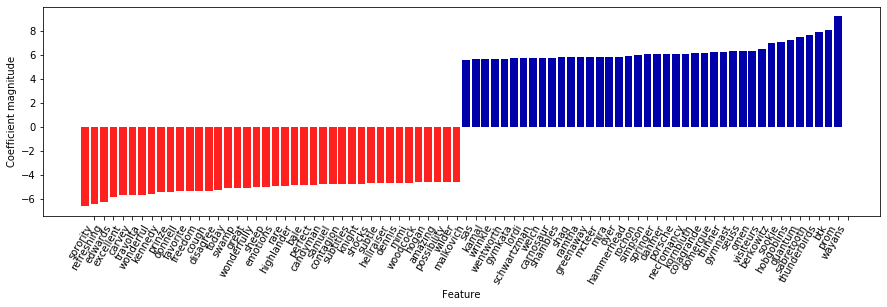

In [11]:
#tf-idf 특성으로 훈련시킨 마지막 모델
# 가장 큰 계수 40개/ 가장 작은 계수 40개

import mglearn

mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps['logisticregression'].coef_[0],
                                    feature_names, n_top_features=40)

여러 단어로 만든 BOW(n-그램)

- BOW 표현 방식은 단어 순서가 완전히 무시되는 단점이 있다. 
- BOW표현 방식이용시 문맥을 고려하는 방법은 토큰 하나의 횟수만 고려하지 않고 옆에 있는 두 세개의 토큰을 함께 고려하는 방식이다. 

  ( n개의 주변 토큰 고려 하는 n-그램)
 
- CountVectorizer, TfidfVectorizer는 ngram_range 매개변수에 특성으로 고려할 토큰의 범위를 지정 가능하다. 
- ngram_range 매개변수의 입력값은 튜플이며 연속된 토큰의 최소 길이와 최대 길이이다. 

In [13]:
# 예제 문장으로 n-그램 확인 / 토큰 하나를 유니그램이라고 한다. 
from sklearn.feature_extraction.text import CountVectorizer

bards_words = ["The fool doth think he is wise, ",
              "but the wise man knows himself to be a fool"]

cv = CountVectorizer(ngram_range=(1,1)).fit(bards_words)

print('어휘 사전 크기 :', len(cv.vocabulary_))
print('어휘 사전 :\n', cv.get_feature_names())

어휘 사전 크기 : 13
어휘 사전 :
 ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [14]:
#토큰 2개가 연속된 바이그램
cv = CountVectorizer(ngram_range=(2,2)).fit(bards_words)

print('어휘 사전 크기 :', len(cv.vocabulary_))
print('어휘 사전 :\n', cv.get_feature_names())

어휘 사전 크기 : 14
어휘 사전 :
 ['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


- 연속된 토큰의 수가 커지면 보통 특성이 더 구체적이고 많이 만들어진다. 
- bard_words에 있는 두 문장 사이에는 공통된 바이 그램이 없다. 

In [15]:
print('변환된 데이터 (밀집 배열) :\n', cv.transform(bards_words).toarray())

변환된 데이터 (밀집 배열) :
 [[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


- 단어 하나가 큰 의미를 가진 경우가 많아 대부분 토큰의 최소길이는 1이다. 
- 많은 경우에 바이그램, 더 나아가 5-그램까지는 도움이 되지만, 특성의 개수가 많아지며, 과대적합될 가능성이 있다. 
- 이론상 바이그램의 수는 유니그램 수의 제곱이 되고, 트라이그램은 유니그램의 세제곱이 되므로 특성이 많이 늘어난다. 

In [16]:
#bard_words에 트라이그램 적용 예

cv = CountVectorizer(ngram_range=(1,3)).fit(bards_words)

print('어휘 사전 크기 :', len(cv.vocabulary_))
print('어휘 사전 :\n', cv.get_feature_names())

어휘 사전 크기 : 39
어휘 사전 :
 ['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [23]:
#리뷰 데이터에 Tfidf적용 그리드 서치로 최적 n-그램 범위 탐색
pipe = make_pipeline(TfidfVectorizer(min_df = 5), LogisticRegression())

#매개변수 조합 많고, 트라이그램 포함되어 그리드 실행 시간 오래 걸린다. 
param_grid = {'logisticregression__C':[0.01,0.1,1,10],
             'tfidfvectorizer__ngram_range':[(1,1),(1,2),(1,3)]}

grid = GridSearchCV(pipe, param_grid, cv = 3)
grid.fit(text_train, y_train)
print('최상 교차 검증 점수 :', grid.best_score_)
print('최적 매개변수 :', grid.best_params_)

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Futur

최상 교차 검증 점수 : 0.7145066666666666
최적 매개변수 : {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 1)}


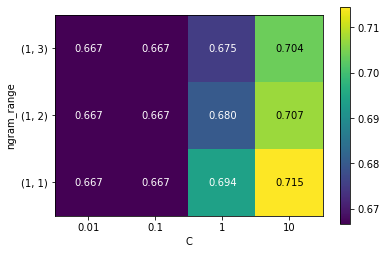

In [24]:
import matplotlib.pyplot as plt

#그리드 서치에서 테스트 점수 추출
scores = grid.cv_results_['mean_test_score'].reshape(-1,3).T

#히트맵 그리기
heatmap = mglearn.tools.heatmap( scores, xlabel = "C", ylabel ='ngram_range', cmap = 'viridis', fmt = '%.3f',
                               xticklabels = param_grid['logisticregression__C'],
                               yticklabels = param_grdi['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

- 본 교재에서는 param_grid의 C값의 로그스케일과, n-그램의 갯수가 많아  C = 100, n-gram = (1,3)에서
  
  정확도가 향상 되었지만, 너무 오래걸리는 분석환경으로 param_grid의 매개변수 값을 축소하여 성능향상이 일어나지 않았다. 

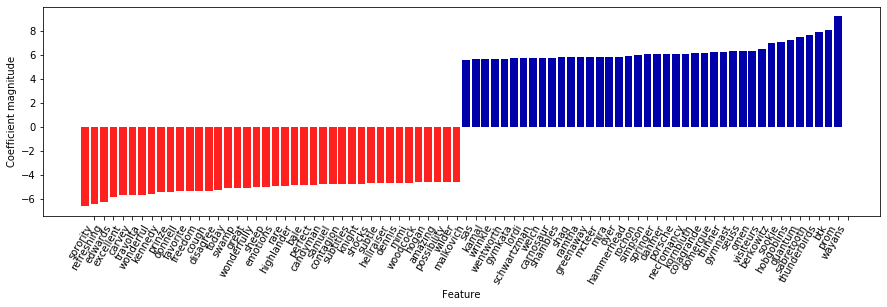

In [26]:
#특성 이름과 계수 추출
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

- 유니그램 모델에서는 없던 단어들이 생겼고, 앞 뒤의 문맥에 따라 유의미한 결과를 내포하는 단어를 탐색 할 수 있다.
- 트라이 그램 이용시 영향력이 큰 바이그램과 트라이그램의 대부분은 독립적일 땐 큰 의미가 없는 단어들로 구성되어 있다.
- 이런 특성으로 인한 영향은 유니그램의 중요도와 비교했을 때 상당히 제한적이다. 

고급 토큰화, 어간 추출, 표제어 추출

- CountVectorizer, TfidfVectorizer보다 더 정교한 방법은 BOW 모델의 첫 단계인 토큰화에서

  단어가 무엇으로 구성되었는지 정의한다. 영어 같은 경우 한단어에서 파생되거나 복수, 단수 단어가 함께 포함되어
  
  이를 구분하면 과대적합되기 쉽고, 모델이 훈련 데이터를 완전하게 활용하지 못한다. 
  
- 여려 동사형, 명사의 단수 복수, 동명사 등 관련 단어들을 다른 토큰으로 다루면 모델 일반화에 도움이 된다. 
    - 단어를 어간으로 표현하여 같은 어간을 가진 모든 단어를 구분(또는 합침) = 어간추출
    - 알려진 단어의 형태 사전을 이용하고 문장에서 단어의 역할을 고려하는 처리 방식 = 표제어 추출

- 표제어 추출과 어간 추출은 단어의 일반 형태를 추출하는 정규화의 한 형태로 볼 수 있다. 

- nltk를 이용해 어간 추출을 하고 spacy를 이용해 표제어 추출 진행

(spacy 라이브러리설치시 파이썬 3.8호환 문제 cl.exe를 제대로 불러오지 못하는 오류로 인하여 예제만 작성 )

In [ ]:
import nltk
# import spacy
# spacy의 영어 모듈 다운 후 link 오류 발생으로 오류 해결 후 실습 예정

In [ ]:
# print('spacy 버전 ', spacy.__version__)
print('nltk 버전 ', nltk.__version__)

In [ ]:
#spacy 영어모델 로드
# en_nlp = spacy.load('en')

#nltk의 PorterStemmer 객체 생성
stemmer = nltk.stem.PorterStemmer()

In [ ]:
def compare_normalization(doc):
    #spac 문서 토큰화
    #dco_spacy = en_nlp(doc)
    #spac로 탐색한 표제어 추출
    #print('표제어:')
    #print([token.lemma_ for toke in doc_spacy])
    #PortStemmer로 찾은 토큰 출력
    print('어간:')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [ ]:
#비교
compare_normalization(u"Our metting today was worse than yesterday,"
                     "I'm scared of meeting the clients tomorrow.")

- 어간 추출이 항상 단어에서 어간만 남겨놓고 제거하므로 'was'는 'wa'가 되지만 표제어 추출은 올바른 동사형인 'be'를 추출한다. 
 
  (표제어 추출은 정규화 시키고 어간 추출은 meeting과 같은경우 meet으로 바꿨다. )
- 표제어 추출은 어간 추출보다 훨씬 복잡한 처리를 거쳐 어간처리보다 좋은 결과를 낸다. 

In [ ]:
# #spacy 표제어 추출 기능과 CountVectorizer토큰 분할기 이용
# #spacy 언어 모델 로드
# en_nlp = spacy.load('en', disable=['parser', 'ner'])
# #spacy 문서 처리 파이프라인 제작
# def custom_tokenizer(document):
#     doc_spacy = en_nlp(document)
#     return [token.lemma_ for token in doc_spacy]

# #자작 토큰 분할기 이용해 CountVectorizer 객체 생성
lemma_vect = CountVectorizer(tokenizer = custom_tokenizer, min_df = 5)


In [ ]:
# X_train_lemma = lemma_vect.fit_transform(text_train)
# print('X_train_lemma.shape :', X_train_lemma.shape)

#비교를 위한 표준 CountVecterizer
vect = CountVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)
print('X_train.shape', X_train.shape)

- 표제어 추출은 특성 개수를 줄여준다. ( 일부특성을 합쳐 일종의 규제로 볼 수 있다.)
- 따라서 데이터셋이 작아도 성능을 높여 줄 수 있다. 

In [ ]:
#StratifiedShuffleSplit을 사용해 훈련세트의 1%만 훈련폴드로 하고, 나머지는 테스트 폴드로 교차검증 수행

from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.99, train_size = 0.01, random_state = 0)

grid = GridSearchCV(LogisticRegression(), param_grid, cv = cv)

#기본 CountVectorizer
grid.fit(X_train, y_train )
print("최상 교차 검증 점수 "
       "기본 CountVecotrizer".format(grid.best_score_))

#표제어 이용
grid.fit(X_train_lemma, y_train)
print("최상 교차 검증 점수 "
       "기본 CountVecotrizer".format(grid.best_score_))


- 다른 특성 추출 기법들과 마찬가지로 데이터셋에 따라 결과 차이가 있지만, 

  표제어 추출과 어간 추출은 모델을 더 낫거나 간단하게 만들어 주기 때문에 특정 작업시 마지막 성능까지 쥐어짜내야 할때 시도하면 좋다. 